In [80]:
def load_all_snapshots(table_name: str, spark_session: SparkSession):
    folder = SILVER_ROOT / table_name
    all_files = list(folder.glob("silver_*.csv"))

    if not all_files:
        return None

    # Load the first file
    base_df = (
        spark_session.read
        .option("header", True)
        .option("inferSchema", True)
        .csv(str(all_files[0]))
        .withColumn("Customer_ID", lower(trim("Customer_ID")))
    )

    # Union the rest one by one
    for f in all_files[1:]:
        temp_df = (
            spark_session.read
            .option("header", True)
            .option("inferSchema", True)
            .csv(str(f))
            .withColumn("Customer_ID", lower(trim("Customer_ID")))
        )
        base_df = base_df.unionByName(temp_df)

    return base_df

In [81]:
lms  = load_all_snapshots("lms_loan_daily", spark)
clk  = load_all_snapshots("feature_clickstream", spark)
fin  = load_all_snapshots("features_financials", spark)
attr = load_all_snapshots("features_attributes", spark)

In [82]:
fin  = fin.drop("snapshot_date")
attr = attr.drop("snapshot_date")

In [83]:
from pyspark.sql.functions import trim, lower

def clean_customer_id(df):
    return df.withColumn("Customer_ID", lower(trim("Customer_ID")))

lms  = clean_customer_id(lms)
clk  = clean_customer_id(clk)
fin  = clean_customer_id(fin)
attr = clean_customer_id(attr)

In [84]:
# Base table: LMS
df_full = (
    lms
    .join(clk,  on=["Customer_ID", "snapshot_date"], how="left")
    .join(fin,  on=["Customer_ID"], how="left")
    .join(attr, on=["Customer_ID"], how="left"))

In [85]:
print("Total features:", len(df_full.columns))
df_full.printSchema()

Total features: 67
root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- loan_id: string (nullable = true)
 |-- loan_start_date: date (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- installment_num: integer (nullable = true)
 |-- loan_amt: integer (nullable = true)
 |-- due_amt: double (nullable = true)
 |-- paid_amt: double (nullable = true)
 |-- overdue_amt: double (nullable = true)
 |-- balance: double (nullable = true)
 |-- mob: integer (nullable = true)
 |-- installments_missed: integer (nullable = true)
 |-- first_missed_date: string (nullable = true)
 |-- dpd: integer (nullable = true)
 |-- fe_1: double (nullable = true)
 |-- fe_2: double (nullable = true)
 |-- fe_3: double (nullable = true)
 |-- fe_4: double (nullable = true)
 |-- fe_5: double (nullable = true)
 |-- fe_6: double (nullable = true)
 |-- fe_7: double (nullable = true)
 |-- fe_8: double (nullable = true)
 |-- fe_9: double (nullable = true)
 |-- fe_10: double (

In [87]:
useful_cols = [
    "Customer_ID", "snapshot_date",
    "loan_amt", "due_amt", "paid_amt", "overdue_amt",
    "mob", "installments_missed", "dpd",
    *[f"fe_{i}" for i in range(1, 21)],
    "clickstream_mean",
    "Annual_Income", "Num_Bank_Accounts", "Num_Credit_Card",
    "Num_of_Loan", "Num_of_Delayed_Payment", "Changed_Credit_Limit",
    "Credit_Mix", "Outstanding_Debt", "Amount_invested_monthly",
    "Payment_of_Min_Amount", "Payment_Behaviour",
    "is_min_pay_only", "min_pay_info_missing",
    "credit_history_months", "credit_history_years", "dti",
    "Age", "Occupation", "age_band", "has_valid_ssn",
    "Monthly_Balance", "Total_EMI_per_month", "Interest_Rate" 
]

# Select only the relevant columns
df_clean = df_full.select(*useful_cols)

In [88]:
# Spark to Pandas conversion
df = df_clean.toPandas()

In [89]:
df.head()

,Customer_ID,snapshot_date,loan_amt,due_amt,paid_amt,overdue_amt,mob,installments_missed,dpd,fe_1,...,credit_history_months,credit_history_years,dti,Age,Occupation,age_band,has_valid_ssn,Monthly_Balance,Total_EMI_per_month,Interest_Rate
0,cus_0x1000,2024-03-01,10000,1000.0,0.0,6000.0,10,6,182,115.0,...,129,10.750000,0.051032,18.0,Lawyer,18-24,1,400.36080,42.94109,27.0
1,cus_0x1011,2023-11-01,10000,0.0,0.0,0.0,0,0,0,142.0,...,190,15.833333,0.008030,44.0,Doctor,35-44,1,294.10147,123.43494,17.0
2,cus_0x1011,2024-09-01,10000,1000.0,1000.0,0.0,10,0,0,-9.0,...,190,15.833333,0.008030,44.0,Doctor,35-44,1,294.10147,123.43494,17.0
3,cus_0x1013,2024-02-01,10000,1000.0,1000.0,0.0,2,0,0,-34.0,...,214,17.833334,0.012508,44.0,Mechanic,35-44,1,485.88970,228.01808,6.0
4,cus_0x1013,2024-03-01,10000,1000.0,1000.0,0.0,3,0,0,-16.0,...,214,17.833334,0.012508,44.0,Mechanic,35-44,1,485.88970,228.01808,6.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137500 entries, 0 to 137499
Data columns (total 53 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Customer_ID              137500 non-null  object 
 1   snapshot_date            137500 non-null  object 
 2   loan_amt                 137500 non-null  int32  
 3   due_amt                  137500 non-null  float64
 4   paid_amt                 137500 non-null  float64
 5   overdue_amt              137500 non-null  float64
 6   mob                      137500 non-null  int32  
 7   installments_missed      137500 non-null  int32  
 8   dpd                      137500 non-null  int32  
 9   fe_1                     93712 non-null   float64
 10  fe_2                     93712 non-null   float64
 11  fe_3                     93712 non-null   float64
 12  fe_4                     93712 non-null   float64
 13  fe_5                     93712 non-null   float64
 14  fe_6

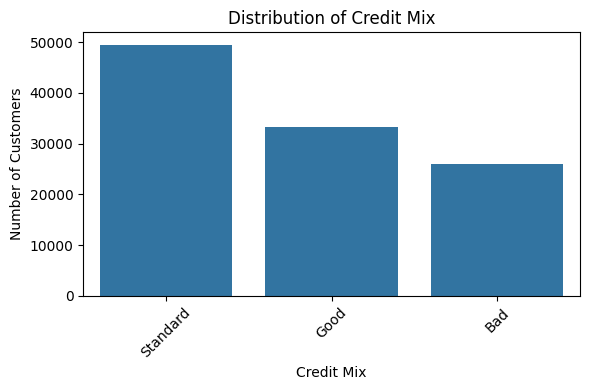

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Credit_Mix", order=df["Credit_Mix"].value_counts().index)
plt.title("Distribution of Credit Mix")
plt.xlabel("Credit Mix")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

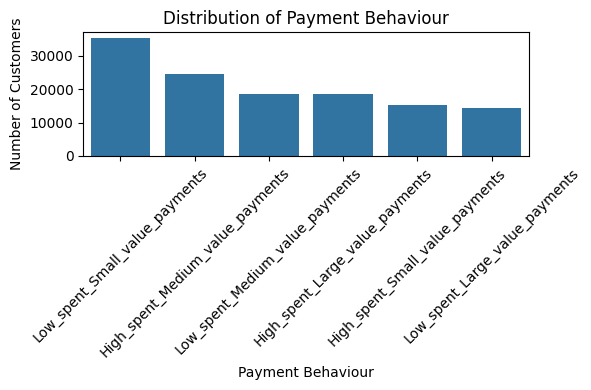

In [92]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Payment_Behaviour", order=df["Payment_Behaviour"].value_counts().index)
plt.title("Distribution of Payment Behaviour")
plt.xlabel("Payment Behaviour")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

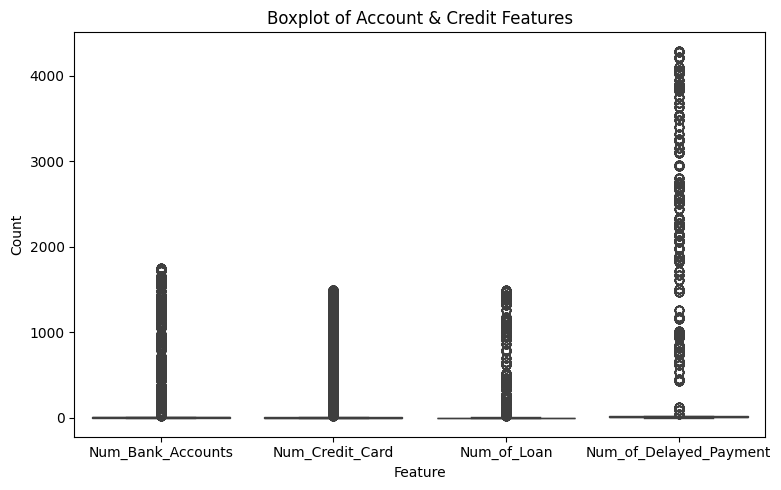

In [98]:
# Subset the relevant columns
cols = ["Num_Bank_Accounts", "Num_Credit_Card", "Num_of_Loan", "Num_of_Delayed_Payment"]

# Melt the DataFrame for grouped boxplot format
df_melted = df[cols].melt(var_name="Feature", value_name="Value")

# Create boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x="Feature", y="Value")
plt.title("Boxplot of Account & Credit Features")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [66]:
import glob
import pandas as pd

label_files = glob.glob("data_mart/gold/label_store/gold_label_store_*.csv")

df_label = pd.concat([pd.read_csv(f) for f in label_files], ignore_index=True)
df_label["Customer_ID"] = df_label["Customer_ID"].str.strip().str.lower()
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   loan_id        12500 non-null  object
 1   Customer_ID    12500 non-null  object
 2   label          12500 non-null  object
 3   label_def      12500 non-null  object
 4   snapshot_date  12500 non-null  object
dtypes: object(5)
memory usage: 488.4+ KB


In [71]:
df_merged = pd.merge(
    df,
    df_label[["Customer_ID", "snapshot_date", "label"]],
    on=["Customer_ID"],
    how="inner"
)

In [72]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137500 entries, 0 to 137499
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Customer_ID              137500 non-null  object 
 1   snapshot_date_x          137500 non-null  object 
 2   loan_amt                 137500 non-null  int32  
 3   due_amt                  137500 non-null  float64
 4   paid_amt                 137500 non-null  float64
 5   overdue_amt              137500 non-null  float64
 6   mob                      137500 non-null  int32  
 7   installments_missed      137500 non-null  int32  
 8   dpd                      137500 non-null  int32  
 9   remaining_term           137500 non-null  float64
 10  days_since_origination   137500 non-null  int32  
 11  fe_1                     93712 non-null   float64
 12  fe_2                     93712 non-null   float64
 13  fe_3                     93712 non-null   float64
 14  fe_4

In [75]:
df_merged.head()

,Customer_ID,snapshot_date_x,loan_amt,due_amt,paid_amt,overdue_amt,mob,installments_missed,dpd,remaining_term,...,bank_num_suspicious,Age,Occupation,age_band,has_valid_ssn,Monthly_Balance,Total_EMI_per_month,Interest_Rate,snapshot_date_y,label
0,cus_0x1000,2024-03-01,10000,1000.0,0.0,6000.0,10,6,182,0.0,...,0,18.0,Lawyer,18-24,1,400.36080,42.94109,27.0,2023-11-01,1
1,cus_0x1011,2023-11-01,10000,0.0,0.0,0.0,0,0,0,10.0,...,0,44.0,Doctor,35-44,1,294.10147,123.43494,17.0,2024-05-01,0
2,cus_0x1011,2024-09-01,10000,1000.0,1000.0,0.0,10,0,0,0.0,...,0,44.0,Doctor,35-44,1,294.10147,123.43494,17.0,2024-05-01,0
3,cus_0x1013,2024-02-01,10000,1000.0,1000.0,0.0,2,0,0,8.0,...,0,44.0,Mechanic,35-44,1,485.88970,228.01808,6.0,2024-06-01,0
4,cus_0x1013,2024-03-01,10000,1000.0,1000.0,0.0,3,0,0,7.0,...,0,44.0,Mechanic,35-44,1,485.88970,228.01808,6.0,2024-06-01,0


In [94]:
df_num = df.select_dtypes(include=['number'])
corr_matrix = df_num.corr()

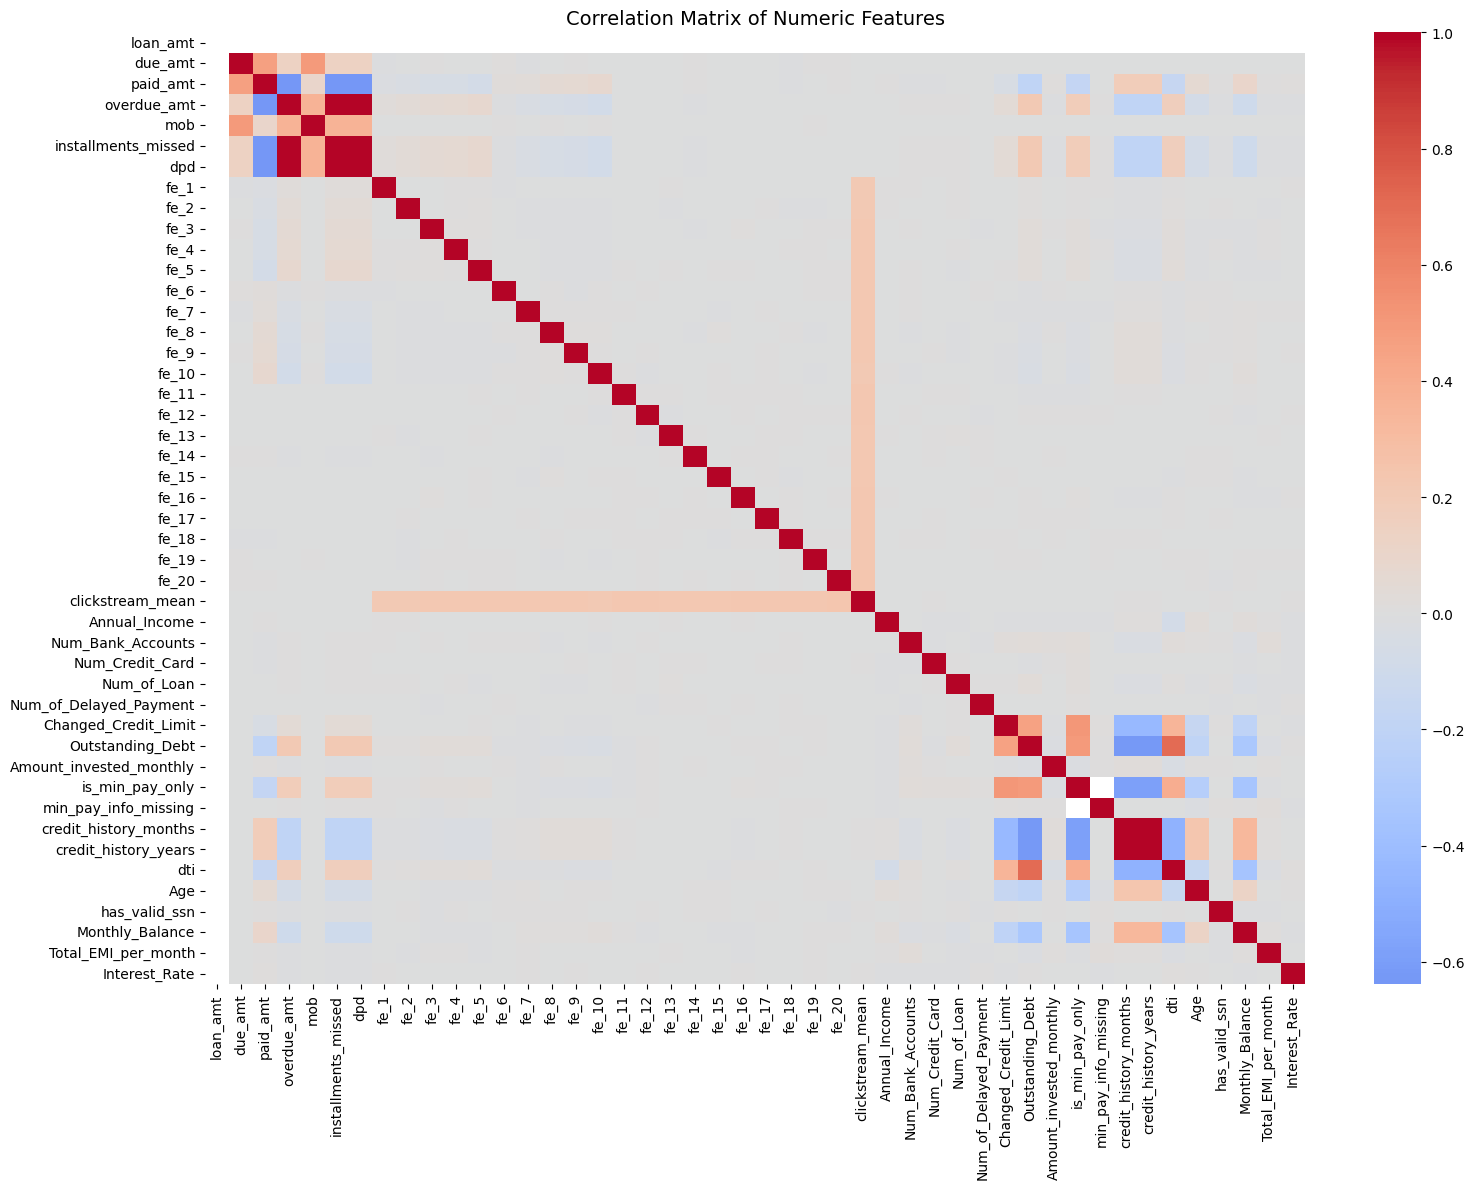

In [95]:
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

In [96]:
# Flatten the matrix and filter high correlations (excluding self-correlation)
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]

# Drop self-pairs and keep one direction only
corr_pairs = corr_pairs[corr_pairs["Feature1"] != corr_pairs["Feature2"]]
corr_pairs = corr_pairs.drop_duplicates(subset=["Correlation"])

# Filter by threshold
high_corr = corr_pairs[abs(corr_pairs["Correlation"]) > 0.7]
high_corr.sort_values("Correlation", ascending=False)

,Feature1,Feature2,Correlation
143,overdue_amt,installments_missed,1.000000
1787,credit_history_months,credit_history_years,1.000000
144,overdue_amt,dpd,0.999976
236,installments_missed,dpd,0.999976
1604,Outstanding_Debt,dti,0.701180


In [ ]:
import pandas as pd

def engineer_lms_features(df: pd.DataFrame) -> pd.DataFrame:
    # Preprocess
    df = df.copy()
    df["snapshot_date"] = pd.to_datetime(df["snapshot_date"])
    df.sort_values(["Customer_ID", "snapshot_date"], inplace=True)

    # Core calculations
    df["payment_ratio"] = df["paid_amt"] / df["due_amt"].replace(0, 1e-6)
    df["missed_payment"] = (df["paid_amt"] < df["due_amt"]).astype(int)
    df["full_payment"] = (df["paid_amt"] >= df["due_amt"]).astype(int)

    # Rolling calculations over 3 months (adjust window size if needed)
    rolling = (
        df.groupby("Customer_ID")
          .rolling(window=3, on="snapshot_date", min_periods=1)
          .agg({
              "payment_ratio": "mean",
              "dpd": ["max", lambda x: x.iloc[-2] if len(x) > 1 else None],
              "missed_payment": "sum"
          })
          .reset_index()
    )
    rolling.columns = ["Customer_ID", "index", 
                       "rolling_avg_payment_ratio_3m", 
                       "max_dpd_3m",
                       "missed_count_3m"]
    df = df.reset_index().merge(rolling.drop(columns="index"), on=["Customer_ID", "index"])

    # Time since last full payment
    df["months_since_full_payment"] = (
        df.groupby("Customer_ID")["full_payment"]
          .apply(lambda x: x[::-1].cumsum()[::-1].where(x == 1).ffill().bfill().fillna(0))
    )

    # Consecutive missed/partial ending current
    def compute_consecutive_missed(group):
        streak = 0
        result = []
        for paid, due in zip(group["paid_amt"], group["due_amt"]):
            if paid < due:
                streak += 1
            else:
                streak = 0
            result.append(streak)
        return result

    df["consec_missed"] = (
        df.groupby("Customer_ID").apply(compute_consecutive_missed)
          .explode().astype(int).reset_index(drop=True)
    )

    return df